In [181]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
import fastdtw as fastdtw
from tslearn.utils import to_time_series_dataset

In [182]:
def load_npy(filename):
    return np.load(filename)


dir_path = 'cleaned_time_series/'
len_threshold = 1280
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = load_npy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)
print(len(X))

10000


In [161]:
from pyts.approximation import paa as paa

# Initialize PAA transformer
approximator = paa.PiecewiseAggregateApproximation(window_size=4)

# Apply PAA to your time series data
X_paa = approximator.transform(X.reshape(-1, 1280))

print(X_paa.shape)

(10000, 320)


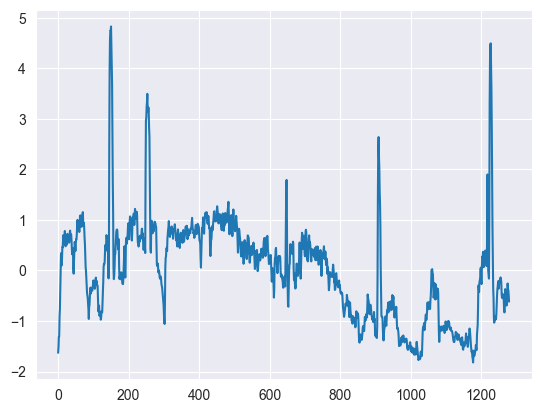

In [89]:
# plot first ts before paa
plt.plot(X[0].reshape(-1))
plt.show()

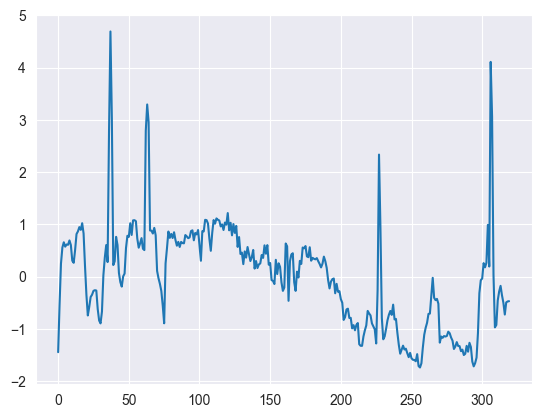

In [90]:
# plot first ts after paa
plt.plot(X_paa[0].reshape(-1))
plt.show()

In [104]:
# Encode the class labels as integers
y = LabelEncoder().fit_transform(y)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paa.reshape(-1,1,320), y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1, 320), (2000, 1, 320), (8000,), (2000,))

In [99]:
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN with Euclidean

In [100]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
# classification_report
from sklearn.metrics import classification_report
knn = KNeighborsTimeSeriesClassifier(n_neighbors=6, distance="euclidean", n_jobs=-1)
knn.fit(X_train_scaled, y_train)

y_pred_multi = knn.predict(X_test_scaled)
print(f'Accuracy score:{accuracy_score(y_test, y_pred_multi)}')
print(classification_report(y_test, y_pred_multi))

Accuracy score:0.111
                   precision    recall  f1-score   support

              emo       0.05      0.19      0.07       100
             folk       0.11      0.15      0.13       100
             goth       0.08      0.07      0.08       100
            happy       0.12      0.48      0.20       100
      heavy-metal       0.04      0.06      0.05       100
       honky-tonk       0.11      0.06      0.08       100
           j-idol       0.08      0.22      0.11       100
             kids       0.25      0.01      0.02       100
   minimal-techno       0.78      0.32      0.45       100
              mpb       0.00      0.00      0.00       100
          new-age       0.22      0.06      0.09       100
            opera       0.10      0.23      0.14       100
            piano       0.20      0.01      0.02       100
progressive-house       0.28      0.17      0.21       100
            salsa       0.00      0.00      0.00       100
        sertanejo       0.50      

# Shapelets

In [4]:
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.preprocessing import LabelEncoder
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sklearn.metrics import classification_report

Shapelets are subsequences that can be used to represent a class. Matrix profiles make it possibile to identify these shapelets.


In [106]:
st = ShapeletTransformClassifier()

In [107]:
%%time
st.fit(X_train_scaled, y_train)
y_pred = st.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform

In [108]:
rst = RandomShapeletTransform(n_shapelet_samples=4000, max_shapelets=1, min_shapelet_length=5, max_shapelet_length=20, n_jobs=-1) #n_jobs -1 uses all processors

In [109]:
%%time
rst.fit(X_train_scaled, y_train)

KeyboardInterrupt: 

In [15]:
%%time
shapelets_distances_train = rst.transform(X_train_scaled[:50])
shapelets_distances_test = rst.transform(X_test_scaled[:50])

CPU times: user 2.62 s, sys: 133 ms, total: 2.76 s
Wall time: 3.51 s


In [19]:
dt = DecisionTreeClassifier()
dt.fit(shapelets_distances_train, y_train[:50])
y_pred = dt.predict(shapelets_distances_test)
print(classification_report(y_test[:50], y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.33      0.25      0.29         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         0
           9       0.17      0.33      0.22         3
          10       0.00      0.00      0.00         4
          11       0.22      0.50      0.31         4
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         3
          18       0.00    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

# Shapelets with tslearn

In [156]:
from tensorflow.keras.optimizers import Adam
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict

In [162]:
# I need to convert the data genres in y to numerical values
le = LabelEncoder()
y = le.fit_transform(y)

In [163]:
# transform X_paa from this shape (10000, 320) to this shape (10000, 1, 320)
X_paa = X_paa.reshape(X_paa.shape[0], 1, X_paa.shape[1])
X_paa.shape

(10000, 1, 320)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paa, y, test_size=0.2, random_state=42, shuffle=False
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1, 320), (2000, 1, 320), (8000,), (2000,))

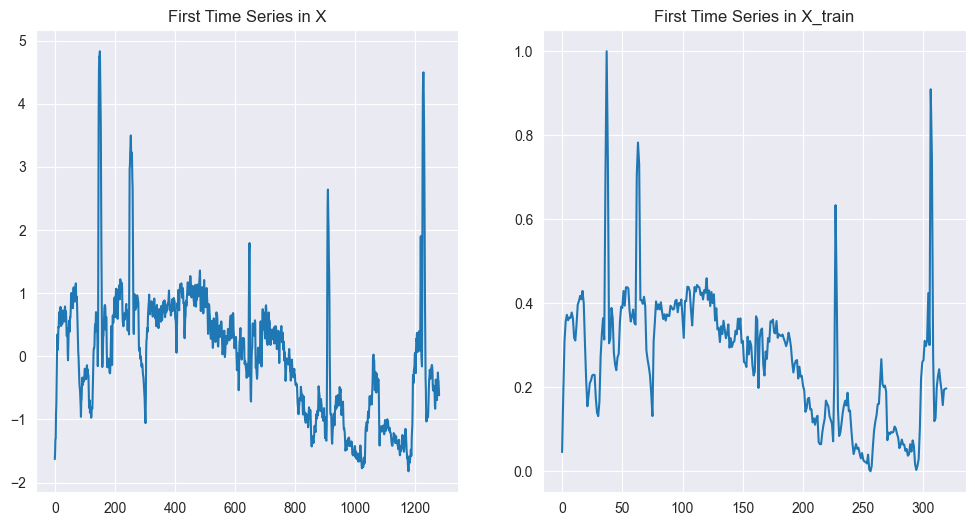

In [171]:
# How do i plot ts 1 from X and ts 1 from X_train? Knowing that X is the original dataset and X_train is the dataset after the split so the index of the ts is different
# Plot the first time series from X
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(X[0].ravel())
plt.title('First Time Series in X')

# Plot the first time series from X_train
plt.subplot(1, 2, 2)
plt.plot(X_train_scaled[0].ravel())
plt.title('First Time Series in X_train')

plt.show()

In [167]:
# Adapt X to tslearn format
X_train = to_time_series_dataset(X_train)
X_test = to_time_series_dataset(X_test)

In [168]:
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [112]:
X_train_scaled.shape, X_test_scaled.shape

((8000, 1, 320), (2000, 1, 320))

In [170]:
# To work with the tslearn library, we need to reshape the data where the first dimension is the number of time series, the second dimension is the number of points in each time series, and the third dimension is the number of dimensions (in this case, 1 since we have univariate time series).
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[2], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[2], 1)

X_train_scaled.shape, X_test_scaled.shape

((8000, 320, 1), (2000, 320, 1))

SHOULD BE ((8000, 1280, 1), (2000, 1280, 1))

In [90]:
adam = Adam(learning_rate=0.01)

In [91]:
%%time
# We will extract 1 shapelet and align it with a time series
shapelet_sizes = {16: 1200}


# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.001,
                            optimizer=adam,
                            max_iter=2000,
                            verbose=1,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - categorical_accuracy: 0.0914 - categorical_crossentropy: 2.9243 - loss: 2.9649
Epoch 2/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - categorical_accuracy: 0.1524 - categorical_crossentropy: 2.7271 - loss: 2.7839
Epoch 3/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - categorical_accuracy: 0.1726 - categorical_crossentropy: 2.6558 - loss: 2.7209
Epoch 4/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - categorical_accuracy: 0.1918 - categorical_crossentropy: 2.6120 - loss: 2.6813
Epoch 5/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - categorical_accuracy: 0.1897 - categorical_crossentropy: 2.5812 - loss: 2.6553
Epoch 6/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - categorical_accuracy: 0.1986 - categorical_crossentropy: 2.5589 - loss: 2.6368
Epoch 7/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - categorical_accuracy: 0.1983 - categorical_crossentropy: 2.5388 - loss: 2.6195
Epoch 8/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - catego

LearningShapelets(max_iter=2000, n_shapelets_per_size={16: 1200},
                  optimizer=<keras.src.optimizers.adam.Adam object at 0x35057e790>,
                  random_state=42, verbose=1, weight_regularizer=0.001)

In [172]:
# Get the number of extracted shapelets, the (minimal) distances from
# each of the timeseries to each of the shapelets, and the corresponding
# locations (index) where the minimal distance was found
n_shapelets = sum(shapelet_sizes.values())
distances = shp_clf.transform(X_train_scaled)
predicted_locations = shp_clf.locate(X_train_scaled)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


In [173]:
n_shapelets

1200

In [174]:
distances

array([[0.60604024, 0.2622862 , 0.17989457, ..., 3.321085  , 1.1103975 ,
        4.129467  ],
       [0.5865207 , 0.9663508 , 1.0321078 , ..., 3.273097  , 1.5503232 ,
        4.034935  ],
       [0.34539962, 0.5141226 , 0.24840641, ..., 2.2900534 , 1.2387195 ,
        1.086607  ],
       ...,
       [1.0186393 , 1.4706514 , 1.4081056 , ..., 3.0071096 , 1.961266  ,
        3.382883  ],
       [0.64516115, 0.5327542 , 0.39412427, ..., 2.6880445 , 1.0186219 ,
        1.9079876 ],
       [0.71529007, 0.76814735, 0.47552562, ..., 3.6410494 , 1.0990093 ,
        4.178981  ]], dtype=float32)

In [175]:
predicted_locations

array([[161,  97, 133, ..., 223, 154, 302],
       [195,   7, 265, ..., 253, 222, 270],
       [ 43,  65, 106, ..., 184,  40, 125],
       ...,
       [176, 211, 219, ...,  70, 114,  97],
       [297, 159, 110, ..., 164, 153, 208],
       [106, 252, 302, ..., 137, 254,  28]])

In [176]:
# We can extract the shapelets from the model
shapelets = shp_clf.shapelets_
shapelets

array([array([[ 0.58806849],
              [-0.20622315],
              [-0.06178828],
              [ 1.9231751 ],
              [ 3.04367328],
              [ 2.16049647],
              [-0.05915559],
              [-0.63948184],
              [ 0.171147  ],
              [ 0.11508286],
              [-0.05577735],
              [-0.19582944],
              [ 1.07197285],
              [ 1.78831697],
              [ 1.88376248],
              [ 2.39381647]]), array([[ 0.27301913],
                                      [ 1.02620804],
                                      [ 1.09745026],
                                      [ 1.07559037],
                                      [ 0.62912995],
                                      [ 1.24055564],
                                      [ 1.54981363],
                                      [ 0.68406826],
                                      [ 1.55303907],
                                      [ 1.98129666],
                                   

In [124]:
y[4]

8

In [119]:
# Try to predict the class of the time series
shp_clf.predict(X_test_scaled[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([13, 15, 16, 15, 15])

In [72]:
# reshape y_test (1, 2000, 1) to (2000, 1)
y_test = y_test.reshape(y_test.shape[1], y_test.shape[0])

IndexError: tuple index out of range

VEDIAMO I VARI PARAMETRI
- 50 con 1 -> 0.1 with 500 iter
- 50 con 200 -> 0.34 with 500 iter (tempo esex 50min)
- 50 con 800 -> 0.34 with 1000 iter (tempo esex 2h 30min)
- 100 con 200 -> 0.231 with 100 iter (tempo esex 7min)
- After PAA 30 con 800 -> 0.30 with 100 iter (tempo esex 14min)

In [177]:
# Check if the predictions are correct
shp_clf.score(X_test_scaled, y_test)
# classification report
from sklearn.metrics import classification_report
y_pred = shp_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
              precision    recall  f1-score   support

           0       0.98      0.48      0.64        88
           1       0.60      0.65      0.63       104
           2       0.93      0.12      0.22       104
           3       0.91      0.71      0.80        87
           4       0.82      0.57      0.67       105
           5       0.52      0.83      0.64       103
           6       0.77      0.71      0.74        93
           7       0.54      0.81      0.65       100
           8       0.95      0.80      0.87        95
           9       0.87      0.46      0.61       114
          10       0.76      0.74      0.75        96
          11       1.00      0.06      0.12        94
          12       0.83      0.60      0.70       103
          13       0.64      0.85      0.73       110
          14       0.81      0.75      0.78       102
          15       0.25      0.93      0.39       109
    

In [149]:
# print the int genres with the labeled genres
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
original_labels = encoder.classes_

# Print encoded labels mapping
for i, label in enumerate(original_labels):
    print(f"{label} -> {i}")

emo -> 0
folk -> 1
goth -> 2
happy -> 3
heavy-metal -> 4
honky-tonk -> 5
j-idol -> 6
kids -> 7
minimal-techno -> 8
mpb -> 9
new-age -> 10
opera -> 11
piano -> 12
progressive-house -> 13
salsa -> 14
sertanejo -> 15
sleep -> 16
songwriter -> 17
synth-pop -> 18
world-music -> 19


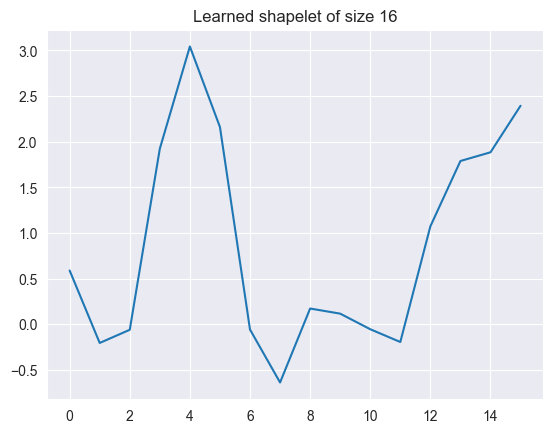

In [125]:
# Plot the shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.title("Learned shapelet of size %d" % sz)
    plt.plot(shapelets[i].ravel())
plt.show()

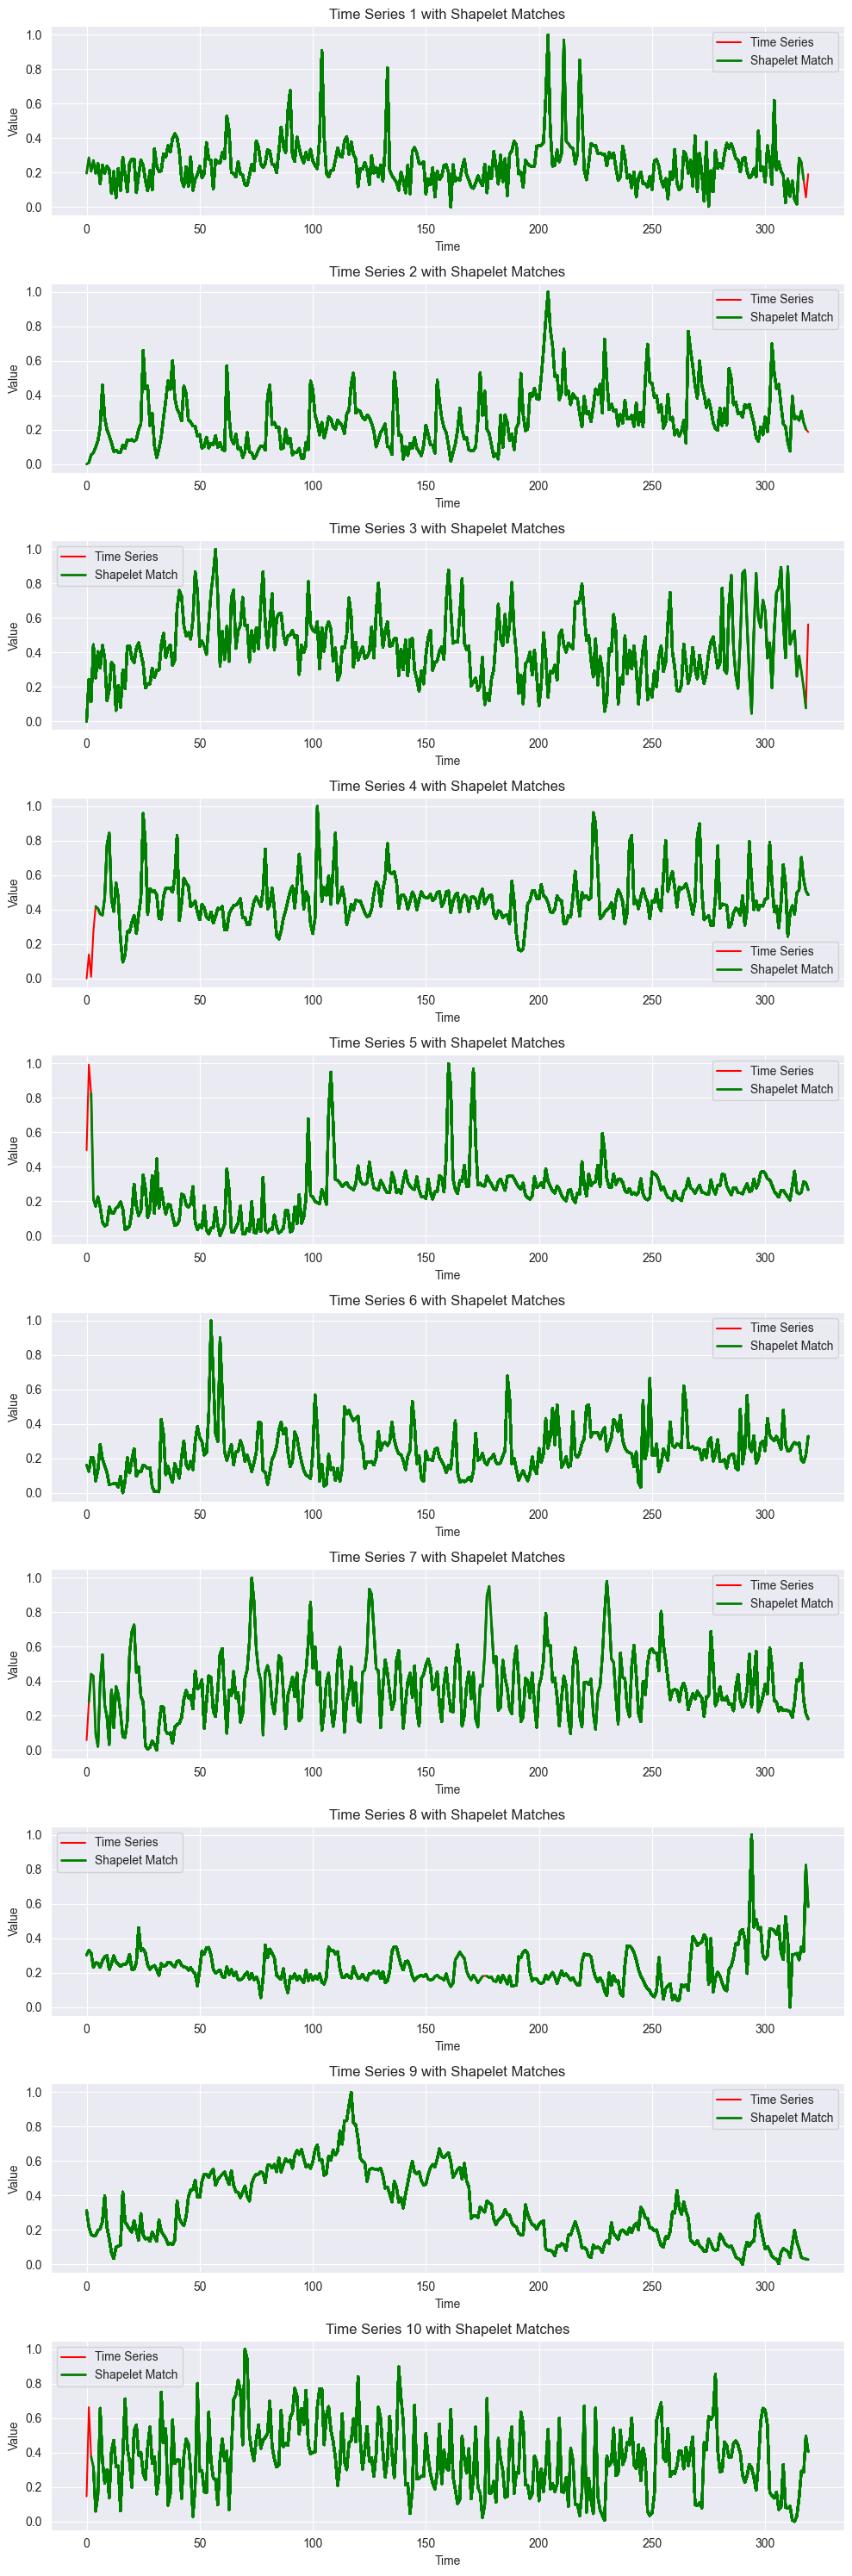

In [126]:
num_instances = 10

# Set up the figure and subplots
fig, axs = plt.subplots(num_instances, 1, figsize=(10, num_instances * 3))

# Iterate through each instance and corresponding axes
for idx, ax in enumerate(axs):
    # Plot the time series
    ax.plot(X_train_scaled[idx].ravel(), "r-", label='Time Series')

    # Find and plot each shapelet
    for shp_idx, shp in enumerate(shapelets):
        # Get the start position of this shapelet in the time series
        start_pos = predicted_locations[idx, shp_idx]

        if start_pos != -1:  # Only plot if the shapelet matches the time series
            # Extract the segment of the time series where the shapelet matches
            matched_segment = X_train_scaled[idx, start_pos:start_pos + len(shp)].ravel()
            ax.plot(range(start_pos, start_pos + len(shp)), matched_segment, "g-", linewidth=2, label='Shapelet Match' if shp_idx == 0 else "")



    # Enhance plot
    ax.legend()
    ax.set_title(f"Time Series {idx + 1} with Shapelet Matches")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Plot only the most important shapelets and not all the shapelets that match the ts

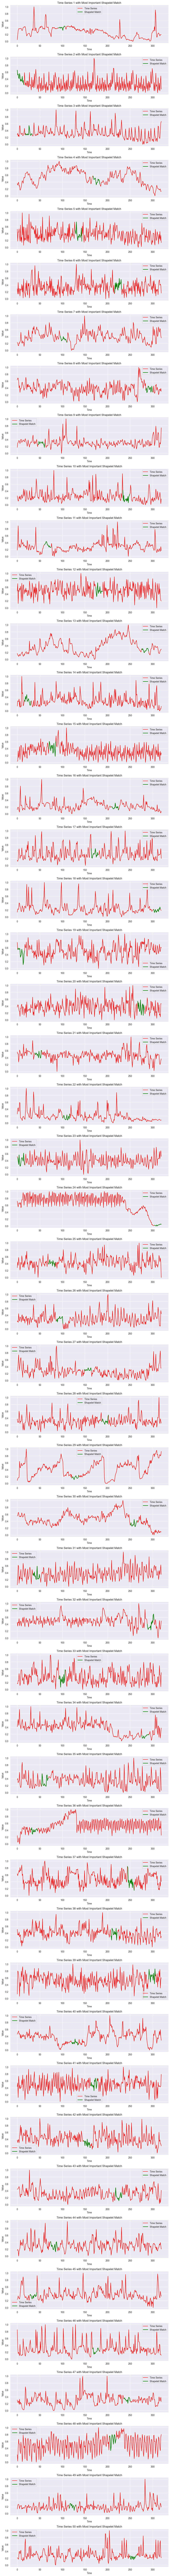

In [179]:
num_instances = 50

# Set up the figure and subplots
fig, axs = plt.subplots(num_instances, 1, figsize=(10, num_instances * 3))

# Iterate through each instance and corresponding axes
for idx, ax in enumerate(axs):
    # Plot the time series        
        
        
        ax.plot(X_train_scaled[idx].ravel(), "r-", label='Time Series')

    # Find the shapelet with the smallest distance to the time series
        min_dist_idx = np.argmin(distances[idx])

    # Get the start position of this shapelet in the time series
        start_pos = predicted_locations[idx, min_dist_idx]

    # Extract the shapelet
        shp = shapelets[min_dist_idx]

        if start_pos != -1:  # Only plot if the shapelet matches the time series
        # Extract the segment of the time series where the shapelet matches
             matched_segment = X_train_scaled[idx, start_pos:start_pos + len(shp)].ravel()
             ax.plot(range(start_pos, start_pos + len(shp)), matched_segment, "g-", linewidth=2, label='Shapelet Match')

    # Enhance plot
        ax.legend()
        ax.set_title(f"Time Series {idx + 1} with Most Important Shapelet Match")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [139]:
X_train_scaled

array([[[0.19565796],
        [0.28658992],
        [0.20603455],
        ...,
        [0.15696735],
        [0.05493026],
        [0.19010326]],

       [[0.        ],
        [0.00869817],
        [0.05370356],
        ...,
        [0.24216817],
        [0.20324035],
        [0.18686931]],

       [[0.        ],
        [0.24413799],
        [0.11517747],
        ...,
        [0.19466014],
        [0.07650822],
        [0.56313988]],

       ...,

       [[0.17858589],
        [0.3880963 ],
        [0.41666267],
        ...,
        [0.15693931],
        [0.19345446],
        [0.16763672]],

       [[0.47773687],
        [0.4285216 ],
        [0.19635649],
        ...,
        [0.15478564],
        [0.21413331],
        [0.24287791]],

       [[0.19894098],
        [0.15663311],
        [0.18164083],
        ...,
        [0.20117205],
        [0.18872075],
        [0.18657519]]])

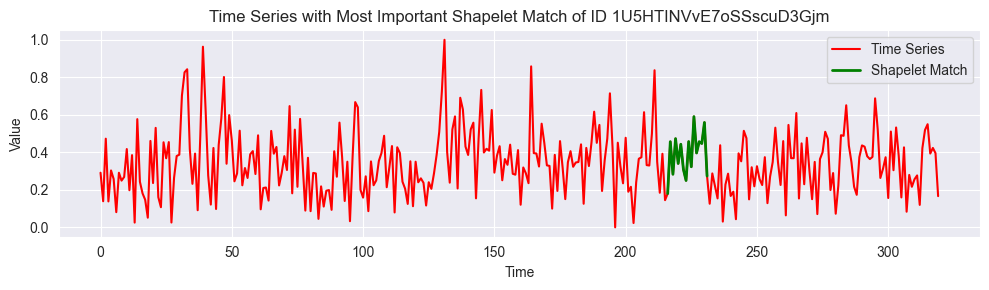

In [180]:
# Assuming X is the specific ID we're interested in
specific_id = "1U5HTINVvE7oSSscuD3Gjm"

# Set up the figure and subplots dynamically based on the number of instances with the specific ID
num_instances = sum(1 for id_val in ids if id_val == specific_id)
fig, axs = plt.subplots(num_instances, 1, figsize=(10, num_instances * 3), squeeze=False)

# Counter for the number of plots created
plot_count = 0


# Iterate through each instance
for idx in range(len(ids)):
    if ids[idx] == specific_id:
        ax = axs[plot_count, 0]  # Access the subplot for the current plot

        # Plot the time series
        ax.plot(X_train_scaled[idx].ravel().T, "r-", label='Time Series')

        # Find the shapelet with the smallest distance to the time series
        min_dist_idx = np.argmin(distances[idx])

        # Get the start position of this shapelet in the time series
        start_pos = predicted_locations[idx, min_dist_idx]

        # Extract the shapelet
        shp = shapelets[min_dist_idx]

        if start_pos != -1:  # Only plot if the shapelet matches the time series
            # Extract the segment of the time series where the shapelet matches
            matched_segment = X_train_scaled[idx, start_pos:start_pos + len(shp)].ravel()
            ax.plot(range(start_pos, start_pos + len(shp)), matched_segment, "g-", linewidth=2, label='Shapelet Match')

        # Enhance plot
        ax.legend()
        ax.set_title(f"Time Series with Most Important Shapelet Match of ID {specific_id}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")

        # Increment the plot counter
        plot_count += 1

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


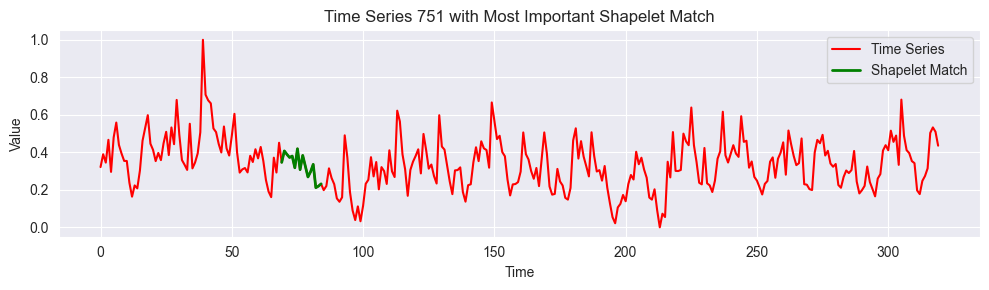

In [132]:
# Assuming x is the index of the time series you want to plot
x_index = 750  # Replace x with the actual index number you're interested in

# Plot the time series with the most important shapelet match
plt.figure(figsize=(10, 3))

# Plot the time series
plt.plot(X_train_scaled[x_index].ravel(), "r-", label='Time Series')

# Find the shapelet with the smallest distance to the time series
min_dist_idx = np.argmin(distances[x_index])

# Get the start position of this shapelet in the time series
start_pos = predicted_locations[x_index, min_dist_idx]

# Extract the shapelet
shp = shapelets[min_dist_idx]

if start_pos != -1:  # Only plot if the shapelet matches the time series
    # Extract the segment of the time series where the shapelet matches
    matched_segment = X_train_scaled[x_index, start_pos:start_pos + len(shp)].ravel()
    plt.plot(range(start_pos, start_pos + len(shp)), matched_segment, "g-", linewidth=2, label='Shapelet Match')

# Enhance plot
plt.legend()
plt.title(f"Time Series {x_index + 1} with Most Important Shapelet Match")
plt.xlabel("Time")
plt.ylabel("Value")

plt.tight_layout()
plt.show()


# Binary shapelet with tslearn 

In [194]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
original_labels = encoder.classes_

# Print encoded labels mapping
for i, label in enumerate(original_labels):
    print(f"{label} -> {i}")

# Indices of classes "heavy-metal" (4) and "piano" (12)
heavy_metal_indices = np.where(y_encoded == 4)[0]  # heavy-metal class index
piano_indices = np.where(y_encoded == 12)[0]       # piano class index

# Combine indices
combined_indices = np.concatenate((heavy_metal_indices, piano_indices))

# Filter X and y based on these indices
X_filtered = X[combined_indices]
y_filtered = y_encoded[combined_indices]
ids_filtered = np.array(ids)[combined_indices]

emo -> 0
folk -> 1
goth -> 2
happy -> 3
heavy-metal -> 4
honky-tonk -> 5
j-idol -> 6
kids -> 7
minimal-techno -> 8
mpb -> 9
new-age -> 10
opera -> 11
piano -> 12
progressive-house -> 13
salsa -> 14
sertanejo -> 15
sleep -> 16
songwriter -> 17
synth-pop -> 18
world-music -> 19


In [195]:
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_filtered, y_filtered, test_size=0.1, random_state=42, stratify=y_filtered
)

X_train_binary.shape, X_test_binary.shape, y_train_binary.shape, y_test_binary.shape

((900, 1, 1280), (100, 1, 1280), (900,), (100,))

In [196]:
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled_binary = scaler.fit_transform(X_train_binary)
X_test_scaled_binary = scaler.transform(X_test_binary)

In [197]:
# shape
X_train_scaled_binary.shape, X_test_scaled_binary.shape

((900, 1, 1280), (100, 1, 1280))

In [198]:
# To work with the tslearn library, we need to reshape the data where the first dimension is the number of time series, the second dimension is the number of points in each time series, and the third dimension is the number of dimensions (in this case, 1 since we have univariate time series).
X_train_scaled_binary = X_train_scaled_binary.reshape(X_train_scaled_binary.shape[0], X_train_scaled_binary.shape[2], 1)
X_test_scaled_binary = X_test_scaled_binary.reshape(X_test_scaled_binary.shape[0], X_test_scaled_binary.shape[2], 1)

X_train_scaled_binary.shape, X_test_scaled_binary.shape

((900, 1280, 1), (100, 1280, 1))

In [199]:
adam = Adam(learning_rate=0.01)

In [200]:
%%time
# We will extract 1 shapelet and align it with a time series
shapelet_sizes = {16: 400}


# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.001,
                            optimizer=adam,
                            max_iter=500,
                            verbose=1,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train_scaled_binary, y_train_binary)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - binary_accuracy: 0.5204 - binary_crossentropy: 0.6889 - loss: 0.6905
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - binary_accuracy: 0.6934 - binary_crossentropy: 0.6637 - loss: 0.6652
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - binary_accuracy: 0.7983 - binary_crossentropy: 0.6111 - loss: 0.6131
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - binary_accuracy: 0.7871 - binary_crossentropy: 0.5485 - loss: 0.5526
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - binary_accuracy: 0.7574 - binary_crossentropy: 0.5061 - loss: 0.5146
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - binary_accuracy: 0.7677 - binary_crossentropy: 0.5055 - loss: 0.5141
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - binary_accuracy: 0.7732 - binary_crossentropy: 0.5054 - loss: 0.5141
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - binary_accuracy: 0.7688 - binary_crossentropy: 0.4850 - loss: 0.4932
Epoch 9/500
4/4 ━━━━━━━━

LearningShapelets(max_iter=500, n_shapelets_per_size={16: 400},
                  optimizer=<keras.src.optimizers.adam.Adam object at 0x40f17b910>,
                  random_state=42, verbose=1, weight_regularizer=0.001)

In [201]:
#Classification report
from sklearn.metrics import classification_report
y_pred = shp_clf.predict(X_test_scaled_binary)
print(classification_report(y_test_binary, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
              precision    recall  f1-score   support

           4       0.91      0.86      0.89        50
          12       0.87      0.92      0.89        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100


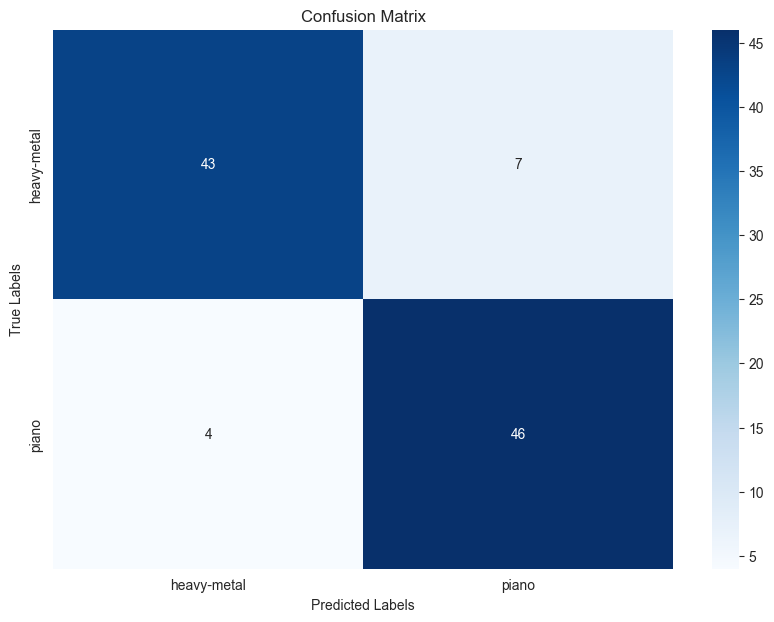

In [208]:
# heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred)

x_tick = ["heavy-metal", "piano"]
y_tick = ["heavy-metal", "piano"]
# confusion matrix heat map with true positive, false positive, true negative, false negative
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=x_tick, yticklabels=y_tick)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()